# Lab on Stochastic Linear Bandits :

We provide the environment to run a standard linear bandit experiment. The objective of this lab session is to understand how to implement LinUCB, the algorithm seen in class and its variant LinTS. We shall see that in practice there are some shortcomings in the implementation to make it efficient so we will guide you to obtain a working version. 

Questions are inline in the notebook and some reserved space are allocated for answers, but feel free to add cells for remarks and run your own experiments to test hypotheses you may have. 


In [1]:
import numpy as np
from model import Environment, Agent
from display import plot_regret


from scipy.stats import bernoulli
from math import log

import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Action generators 
The provided function helps the environment to generate random action sets of size K in dimension d. All actions are renormalized. You can see an example below. 

In [2]:
def randomActionsGenerator(K,d, mean=None):
    """
    K: int -- number of action vectors to be generated
    d : int -- dimension of the action space
    returns : an array of K vectors uniformly sampled on the unit sphere in R^d
    """
    if mean is None:
        mean = np.zeros(d)
    vecs = np.random.multivariate_normal(mean, np.eye(d), size=K)
    norms = np.linalg.norm(vecs,axis=1)
    return vecs / norms[:,np.newaxis]

In [3]:
a = randomActionsGenerator(20,2)

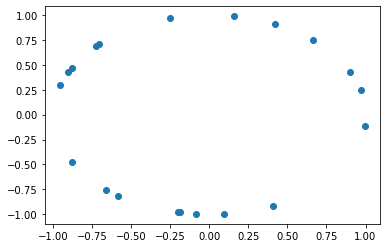

In [4]:
plt.scatter(a[:,0],a[:,1])

# Environment Class

The environment class allows to create 3 types of linear bandit problems: 
* 'fixed' : normally requires a fixed_actions input (otherwise randomly generated at start) which is kept all along the game;
* 'arbitrary': at each round, an 'arbitrary' set of actions is chosen and here we decided to simply create a pool of (d x K) vectors and let the environment choose K of them without replacement at each round;
* 'iid' : at each round, the environment samples K actions at random on the sphere.

For each of these types of game, the class is used to generate the action sets at each round and the reward for a chosen action (chosen by an Agent, see the "Play!" section for the details of the interaction).

In [5]:
class LinearBandit(Environment):
    
    def __init__(self, theta, K, pb_type, var=1., fixed_actions=None):
        """
        theta: d-dimensional vector (bounded) representing the hidden parameter
        K: number of actions per round (random action vectors generated each time)
        """
        self.d = np.size(theta)
        self.theta = theta
        self.K = K
        self.var = var
        self.current_action_set = np.zeros(self.d)
        self.pb_type = pb_type
        if self.pb_type not in ['fixed', 'iid']:
            raise ValueError(pb_type, "this type of problem is unknown, either change it or define it :)")
            
        #Now, set up the game for the given type:
        if self.pb_type == 'fixed':
            if fixed_actions is not None:

                self.K, action_dim = fixed_actions.shape #safety reset of self.K in case different
                if action_dim != self.d: # safety check
                    raise ValueError(fixed_actions, "actions dimension and theta mismatch: fix your actions.")
                self.fixed_actions = fixed_actions
            else:
                #create a fixed action set:
                self.fixed_actions = randomActionsGenerator(self.K, self.d)
            
            self.current_action_set = self.fixed_actions

        elif self.pb_type == 'iid':
            # generate a random set
            self.current_action_set = randomActionsGenerator(self.K, self.d)       
            
        
    def get_action_set(self):
        if self.pb_type == 'fixed':   
            self.current_action_set = self.fixed_actions
            return self.current_action_set
        elif self.pb_type == 'iid':
            self.current_action_set = randomActionsGenerator(self.K, self.d)
            return self.current_action_set
        
        
    def get_reward(self, action):
    
        """ sample reward given action and the model of this bandit environment
        action: d-dimensional vector (action chosen by the learner)
        """
        mean = np.dot(action, self.theta)
        return np.random.normal(mean, scale=self.var)
            
    def get_means(self):
        return np.dot(self.current_action_set, self.theta)
        
        


# Play !
The function play runs one path of regret for one agent. The function experiment runs all agents several (Nmc) times and returns all the logged data. Feel free to check the inputs and outputs required when you decide on the implementation of your own agents.

In [6]:
def play(environment, agent, Nmc, T):
    """
    Play one Nmc trajectories over a horizon T for the specified agent. 
    Return the agent's name (sring) and the collected data in an nd-array.
    """
    
    data = np.zeros((Nmc, T))
    
    
    
    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set) 
            # Note that the main difference with the previous lab is that now get_action needs to receive the action_set
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)
            
            # compute instant regret
            means = environment.get_means()
            best_reward = np.max(means)
            data[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive
            
    return agent.name(), data


def experiment(environment, agents, Nmc, T):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """
    
    all_data = {}
    
    for agent in agents:
        agent_id, regrets = play(environment, agent,Nmc, T)
        
        all_data[agent_id] = regrets
        
    return all_data

# Linear Bandit Agents

For your report, **please export only the notebook from this cell on**. 


## LinUCB : Implementing optimism in $R^d$

As seen in class, the actions are now vectors in $R^d$, representing contextual features, and the environment is assumed to generate rewards according to some hidden linear function $f_\theta(a) = a^\top \theta$. The goal of the learner is thus to estimate $\theta$ while keeping a measure of the uncertainty in all the directions of the feature space. 

* **Baseline: Implementation of LinEpsilonGreedy** In the next cell, we implemented a LinUniform Agent that returns one of the action vectors of the action set, chosen uniformly at random. Please implement an LinEpsilonGreedy agent as seen in the previous Lab. Do you think these agents can have a sublinear regret ? 

*See implementation below. These policies *do not have a sublinear regret* because on at least a fixed portion of the steps, they choose arms uniformly and suffer a linear regret. More precisely, for any fixed $\epsilon>0$, the regret of LinEpsilonGreedy grows in expectation at least like $\epsilon T$ plus some sublinear term due to good convergence of exploitation: after some time, all estimators are concentrated and the exploitation times pull the best arm with high-probability. 
They are decent but weak baselines in principle because they give an idea of what a not-too-smart agent can do. But on the other hand, we are trying to solve linear bandits for the first time so it is a good start.


* **Implementation of LinUCB**: you need to compute UCBs for each arm of the current action set received from the environment, but this time the exploration bonus depends on the history of taken actions and received rewards. 

* **Efficiency of the matrix inversion step**: One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. Remark however that at round $t+1$, the new covariance matrix is very similar to the previous one at rount $t$... Can you think of a way to optimize this step by simply updating the old one ? 
Hint : You can search for a way to compute the inverse of the sum of an invertible matrix A and the outer product, $ uv^\top$, of vectors u and v.

*The Sherman-Morrison formula allows to update $V^{-1}_{t+1}$ with a simple linear update of $V^{-1}_t$ so it does not require to invert the matrix again. A Gauss-Jordan inversion costs $O(d^3)$ (time complexity) to invert to doing it at every round can become very costly when $d$ is large*.


* **Implement and additional exploration hyper-parameter**: It is common practice to modify LinUCB by multiplying the confidence bonus of each arm by some hyperparameter $ 0<\alpha <1 $. 
Please implement this little modification of LinUCB. 

You may wonder why one would do that and it is a legitimate question. We guide you to explore this question further below, bear with us :)

*Multiplying the confidence bonus by an extra factor $ 0<\alpha <1 $ have the bad property of breaking the validity of the confidence interval: as soon as $\alpha <1$ we have no guarantee that the upper bounds we compute actually hold with high probability. On the other hand, it forces the algorithm to exploit faster by shrinking the impact of the uncertainty due to the variance. So we expect it should improve performance in general, but sometimes, it might make the algorithm break if the confidence intervals are violated by some unusual (but unlikely) noisy events.* This should be tested empirically once we have implemented LinUCB (see question below). 



In [7]:
def sherman_morrison(action, old_prec):
    """
    action: vector (1xd)
    old_pred: V_{t-1}^{-1} old precision matrix (dxd)
    """
    d = len(action)
    v_norm = np.dot(action, np.dot(old_prec,action.T))
    denom = 1 + v_norm
    update = np.dot(np.outer(action.T,action),old_prec)/denom
    new_prec = np.dot(old_prec, (np.eye(d)-update))
    
    return new_prec

In [8]:
##TEST

sherman_morrison(np.array([1,0]), np.eye(2))
#should return np.diag(1/2,1)


array([[0.5, 0. ],
       [0. , 1. ]])

### Uniform random policy

In [9]:
class LinUniform(Agent):
  def __init__(self):
    pass

  def get_action(self, arms):
    K, _ = arms.shape
    return arms[np.random.choice(K)]

  def receive_reward(self, chosen_arm, reward):
    pass

  def reset(self):
    pass

  #@staticmethod
  def name(self):
    return 'Unif'

  

### Lin-$\epsilon$-Greedy policy:

In [27]:
from numpy.linalg import pinv

class LinEpsilonGreedy(Agent):
  def __init__(self, d,lambda_reg, eps=0.1,):
    self.eps = eps # exploration probability
    self.d = d
    self.lambda_reg = lambda_reg
    self.reset()
    
  def reset(self):
    self.t = 0
    self.hat_theta = np.zeros(self.d)
    self.cov = self.lambda_reg * np.identity(self.d)
    self.invcov = np.identity(self.d)
    self.b_t = np.zeros(self.d) 

  def get_action(self, arms):
    K, _ = arms.shape
    
    u = np.random.random()
    if u<self.eps:
        return arms[np.random.choice(K)]
    else:
        estimated_means = np.dot(arms, self.hat_theta)
        chosen_arm_index = np.argmax(estimated_means)
        return arms[chosen_arm_index,:]

  def receive_reward(self, chosen_arm, reward):
    """
    update the internal quantities required to estimate the parameter theta using least squares
    """
    
    #update inverse covariance matrix
    xxt = np.outer(chosen_arm, chosen_arm.T)
    self.cov += xxt
#     self.invcov = pinv(self.cov)
    self.invcov = sherman_morrison(chosen_arm,self.invcov)
    
    #update b_t
    self.b_t += reward * chosen_arm

    self.hat_theta = np.inner(self.invcov, self.b_t) # update the least square estimate
    self.t += 1   
        

  #@staticmethod
  def name(self):
    return 'LinEGreedy('+str(self.eps)+')'



### Lin-UCB: The optimistic way

In [28]:


class LinUCB(Agent):

    def __init__(self, d, delta, lambda_reg, alpha=1.):
        self.d = d
        self.delta = delta
        self.lambda_reg = lambda_reg
        self.cov = self.lambda_reg * np.identity(d)


        self.alpha = alpha
        self.reset()

    def reset(self):
        # reset all local variables that should not be kept when the experiment is restarted
        self.t = 0
        self.hat_theta = np.zeros(self.d)
        self.cov = self.lambda_reg * np.identity(self.d)
        self.invcov = np.identity(self.d)
        self.b_t = np.zeros(self.d)  


    def get_action(self, arms):
        """
            This function implements LinUCB
            Input:
            -------
            arms : list of arms (d-dimensional vectors)

            Output:
            -------
            chosen_arm : vector (chosen arm array of features)
            """
        # compute the UCB of each of the arm in arms, here arms are vectors
        #     ucbs = np.array(K)

        #     for i in range(K):
        #         ucbs[i] = 1# use hat_theta and beta and the covariance matrix. beta_n is the upper bound given at the very end of the class

        K, _ = arms.shape
        self.UCBs = np.zeros(K)
        self.beta = np.sqrt(self.lambda_reg) + np.sqrt(2*np.log(1/self.delta) + np.log(1+self.t/(self.d*self.lambda_reg)))  #sqrt(beta)

        for i in range(K):
            a = arms[i,:]
            covxa = np.inner(self.invcov, a.T)
            self.UCBs[i] = np.dot(
                self.hat_theta,a) +  self.alpha * self.beta * np.sqrt(np.dot(a, covxa))

        #print(self.UCBs)

        chosen_arm_index = np.argmax(self.UCBs)
        chosen_arm = arms[chosen_arm_index]
        return chosen_arm


#     return np.random.choice(K)
    

    def receive_reward(self, chosen_arm, reward):
        """
        update the internal quantities required to estimate the parameter theta using least squares
        """
        xxt = np.outer(chosen_arm, chosen_arm.T)
        self.cov += xxt
        #     self.invcov = pinv(self.cov)# pseudo-inverse... could be more efficient with Sherman-Morrison
        self.invcov = sherman_morrison(chosen_arm, self.invcov)

        self.b_t += reward * chosen_arm

        self.hat_theta = np.inner(self.invcov, self.b_t) # update the least square estimate
        self.t += 1

        pass


    def name(self):
        return "LinUCB("+str(self.alpha)+')'

## LinTS : Taking the Bayesian way

Thompson Sampling is a popular bayesian alternative to the standard optimistic bandit algorithms (see Chapter 36 of Bandit Algorithms). The key idea is to rely on Bayesian *samples* to get a proxy for the hidden parameter $\theta$ of the problem instead of building high-probability confidence regions. 

* **Posterior derivation**: Let us place a Gaussian prior with mean $\mathbf{0}$ and covariance $\lambda I$ on $\theta$. Given actions $A_1,\ldots,A_t$ and rewards $Y_1,\ldots,Y_t$, Can you compute the expression of the posterior at the beginning of round $t+1$ ? 

The posterior is 
$$
p(\theta|A_1,Y_1,\ldots,A_t,Y_t) \propto p(A_1,Y_1,\ldots,A_t,Y_t|\theta)p(\theta) \sim \mathcal{N}(\hat{\theta}_t, V^{-1}_t)
$$
A nice way to see this is via the maximum likelihood problem (see https://perso.telecom-paristech.fr/bonald/documents/bandit.pdf) or via the traditional Bayesian posterior derivations for Gaussians with known variance (see https://www.cs.toronto.edu/~rgrosse/courses/csc411_f18/slides/lec19-slides.pdf)

So to implement LinTS, one has to sample from the posterior a *hallucinated* parameter $\tilde{\theta}$ and then use this parameter to evaluate the mean of each arm in the action set at round $t$. Note that the sampling step *replaces* the bonus in LinUCB. 


* **Implementation of a LinTS (Linear Thompson Sampling) agent**.

In [29]:
class LinTS(Agent):

  def __init__(self, d, delta, lambda_prior):
    self.d = d
    self.delta = delta
    self.lambda_prior = lambda_prior
    self.cov = self.lambda_prior * np.identity(d)
    self.reset()

  def reset(self):
    # reset all local variables that should not be kept when the experiment is restarted
    self.t = 0
    self.hat_theta = np.zeros(self.d)
    self.cov = self.lambda_prior * np.identity(self.d)
    self.invcov = np.identity(self.d)
    self.b_t = np.zeros(self.d)  
    

  def get_action(self, arms):
    """
        This function implements LinUCB
        Input:
        -------
        arms : list of arms (d-dimensional vectors)

        Output:
        -------
        chosen_arm : vector (chosen arm array of features)
        """
    # compute the UCB of each of the arm in arms, here arms are vectors
#     ucbs = np.array(K)
    
#     for i in range(K):
#         ucbs[i] = 1# use hat_theta and beta and the covariance matrix. beta_n is the upper bound given at the very end of the class
        
    K, _ = arms.shape
    estimated_means = np.zeros(K)
    
    hallucinated_theta = np.random.multivariate_normal(self.hat_theta, self.invcov)

    for i in range(K):
        estimated_means[i] = np.dot(hallucinated_theta,arms[i,:])
      

    #choose arm with largest estimated mean
    chosen_arm_index = np.argmax(estimated_means)
    chosen_arm = arms[chosen_arm_index]


    return chosen_arm

    

  def receive_reward(self, chosen_arm, reward):
    """
    update the internal quantities required to estimate the parameter theta using least squares
    """
    xxt = np.outer(chosen_arm, chosen_arm.T)
    self.cov += xxt
#     self.invcov = pinv(self.cov) 
    self.invcov = sherman_morrison(chosen_arm, self.invcov)
    
    self.b_t += reward * chosen_arm

    self.hat_theta = np.inner(self.invcov, self.b_t) # update the least square estimate
    self.t += 1
    
    pass


  def name(self):
    return "LinTS"


### Default settings

In [30]:
d = 3  # dimension
K = 7  # number of arms

# parametor vector \theta, normalized :
# theta = randomActionsGenerator(1,d)
theta = np.array([0.45, 0.5, 0.5])
theta /= np.linalg.norm(theta)

T = 1000  # Finite Horizon
N = 50  # Monte Carlo simulations

delta = 0.1 # could be set directly in the algorithms

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

#choice of percentile display
q = 10

In [31]:
# three environments

iid_env = LinearBandit(theta, K, pb_type='iid') 

fixed_actions = np.array(([1,0.1,0.1],[0.1,0.1,1],[0.3,0.3,0.3]))# or... #randomActionsGenerator(K,d)
fixed_env = LinearBandit(theta, K, pb_type='fixed', fixed_actions=fixed_actions) # check if gaps are small
print(fixed_env.get_means())
 
 

[0.65620498 0.70989448 0.51899849]


In [32]:
# policies

linucb = LinUCB(d, delta, lambda_reg=1.)
uniform = LinUniform()
e_greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.)


# Example question: Which baseline is the strongest, LinEpsilonGreedy or LinUniform?
This is a running demo, please follow this "template" in the questions below: 1/ experiment setup (choose environment(s), choose policies and parameters, 2/ plot, 3/ conclude by making observations on your results and responding to the question. 

In [10]:
## iid environment
e_greedy_vs_unif_iid = experiment(iid_env, [uniform, e_greedy], Nmc=N, T=T)

plot_regret(e_greedy_vs_unif_iid, q=10)

NameError: name 'iid_env' is not defined

/Users/julia/Downloads/practice_bandits/display.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


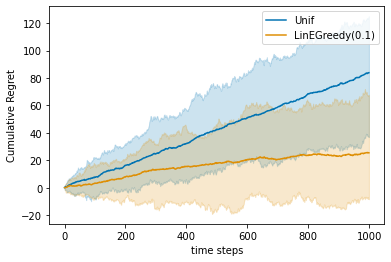

In [36]:
## fixed-actions environment
e_greedy_vs_unif_fixed = experiment(fixed_env, [uniform, e_greedy], Nmc=N, T=T)

plot_regret(e_greedy_vs_unif_fixed, q=10)

**Observations**: We tested LinEspilonGreedy and Uniform on both environment types and LinEpsilonGreedy is stronger (it has lower regret) in both cases. However, we remark that its regret seems linear in all cases as expected due to the non-diminishing amount of exploration, **perhaps it would be interesting to see what happens when we remove this forced exploration?** We note that the difference between Uniform and EGreedy is significantly smaller in the fixed action problem, which is likely due to the reasonably small gaps (~0.05) in this problem (see env setup in above cell). 

**We quickly run the experiment suggested above, to check how Greedy ($\epsilon=0$) performs:**

/Users/julia/Downloads/practice_bandits/display.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()
/Users/julia/Downloads/practice_bandits/display.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


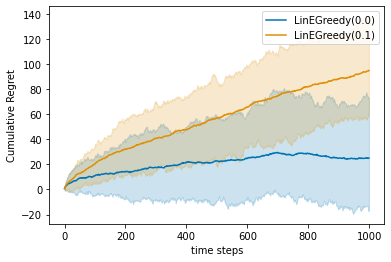

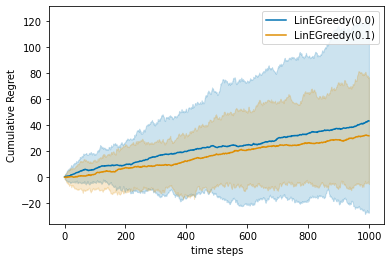

In [37]:
greedy_iid = experiment(iid_env, [greedy, e_greedy], Nmc=N, T=T)
greedy_fixed = experiment(fixed_env, [greedy, e_greedy], Nmc=N, T=T)

plot_regret(greedy_iid, q=10)
plot_regret(greedy_fixed, q=10)

In the iid environment, Greedy seems to be learning! This is surprising and could be investigated further but it is beyond the present question's scope. In the fixed-actions environment, however, greedy has a linear regret. **We conclude that Greedy may actually be quite a strong baseline in iid and arbitrary environments**.

NOTE: the "fixed_env' has been arbitrarily chosen by myself. Other interesting questions include whether ther are choices of hard vs easy problems in the so-called 'fixed-design setting'. This is the topic of the paper 
*The End of Optimism* by Lattimore and Szepesvari, 2017. We will not investigate the question much further here, but remember that the results you observe in the current fixed_env depend on my initial choice. You are welcome to try to change it. 

# Question: Is LinUCB better than the baseline LinEpsilonGreedy? 
Compare the two methods on both environments and conclude. In light of the above example, decide which values of epsilon you want to try in your comparisons and explain your choices following the suggested template.

/Users/julia/Downloads/practice_bandits/display.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()
/Users/julia/Downloads/practice_bandits/display.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


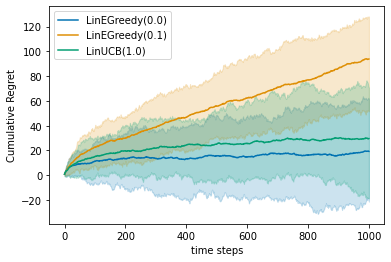

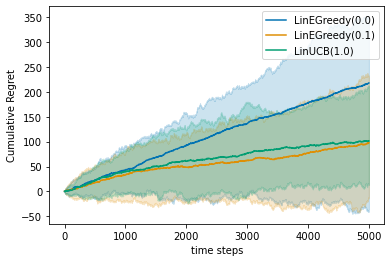

In [38]:
iid_linucb_vs_greedy = experiment(iid_env, [greedy, e_greedy, linucb], Nmc=N, T=T)
fixed_linucb_vs_greedy = experiment(fixed_env, [greedy, e_greedy, linucb], Nmc=N, T=5000) 

plot_regret(iid_linucb_vs_greedy)
plot_regret(fixed_linucb_vs_greedy)


**Conclusions**: LinUCB outperforms LinEpsilonGreedy$(\epsilon=0.1)$ on all problems. Greedy seems to be doing just as well on iid_env but it is the weakest on this fixed-action environment. Overall, LinUCB is the only policy that is able to consistently learn over all environments. 

# Question: What is the role of $\alpha$ for LinUCB ?

In the question above, we saw that the fixed-actions setting is the most interesting because it is the most difficult. For this question, we fix the environment to fixed-actions. 
Compare the behavior of various instantiations of LinUCB using different values of the scaling hyper-parameter $\alpha$ and conclude on its usefulness / risks.


In [39]:
N=50
T=2000

linucb_alpha001 = LinUCB(d, delta, lambda_reg=1., alpha=0.01)
linucb_alpha01 = LinUCB(d, delta, lambda_reg=1., alpha=0.1)
linucb_alpha05 = LinUCB(d, delta, lambda_reg=1., alpha=0.5)
linucb_alpha08 = LinUCB(d, delta, lambda_reg=1., alpha=0.8)



iid_alpha = experiment(iid_env, [greedy, linucb, linucb_alpha001, linucb_alpha01, linucb_alpha05, linucb_alpha08], Nmc=N, T=T)
fixed_alpha = experiment(fixed_env, [greedy, linucb, linucb_alpha001, linucb_alpha01, linucb_alpha05, linucb_alpha08], Nmc=N, T=T)


/Users/julia/Downloads/practice_bandits/display.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


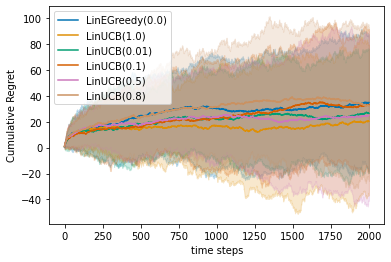

In [40]:
plot_regret(iid_alpha, q=10)

/Users/julia/Downloads/practice_bandits/display.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


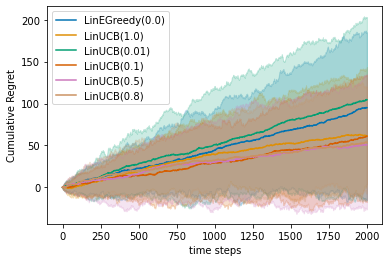

In [41]:
plot_regret(fixed_alpha, q=10)

We expect that small values of alpha should increase exploitation and thus should lead to better (smaller) regret. 
In the fixed arms environment, LinUCB(0.5) performs best, while Greedy fails and LinUCB(0.1) also seems to have a linear regret similar to Greedy. 
This confirms that for some easier problems, introducing a small alpha to control exploration may help reduce the regret, but it remains risky because it may lead to larger regret if the problem is harder than expected (typically, one does not know how hard the problem is before trying).
That being said, the empirical effect is not statistically strong as all regrets above have overlapping confidence regions. 

# Is Thompson Sampling better than LinUCB?
Compare these two policies in all environments and conclude. 


/Users/julia/Downloads/practice_bandits/display.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


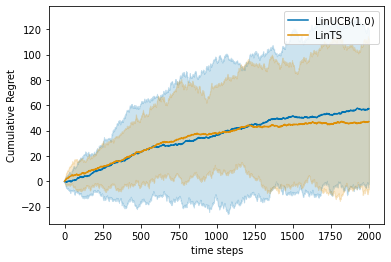

In [42]:
T=2000
N=50

# linucb = LinUCB(T, d, delta, lambda_reg=1.)
ts = LinTS(d, delta, lambda_prior=1.)


linucb_vs_ts_fixed = experiment(fixed_env, [linucb, ts], Nmc=N, T=T)

plot_regret(linucb_vs_ts_fixed, q=10)



**Conclusions**: LinTS and LinUCB are by essence very similar algorithms so we expect they perform similarly. Indeed, this is confirmed by our experiment: the confidence intervals indicate that the small difference in the expectation is not significant to conclude that one method is superior 

It could be interesting to test empirically the impact of the prior for instance, though we do not expect it to be strong. 